In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge,ElasticNet
import joblib

plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'

# df = pd.read_csv('datasets/result_combined_1_2.csv')
egg_data = pd.read_csv('datasets/egg_data.csv')


def create_egg_features(df):
    # Approximate asymmetry: use width/height ratio to decide the offset.
    # This heuristic splits the major axis (height) into two parts.
    # delta is computed so that when width/height > 0.5, a becomes larger.
    ratio = df['width'] / df['height']
    delta = (ratio - 0.5) * (df['height'] / 2)
    
    # Ensure that a is the longer semi-major axis.
    # (If for some samples delta is negative, we swap a and b.)
    a = df['height'] / 2 + delta
    b = df['height'] / 2 - delta
    # In case some computed 'a' is smaller than 'b', swap them:
    a_corrected = np.maximum(a, b)
    b_corrected = np.minimum(a, b)
    
    # Semi major axis ratio: shorter divided by longer
    semi_major_axis_ratio = b_corrected / a_corrected
    
    # Now, for quadrant diagonals we use the polar form of an ellipse.
    # Angle = 45° (in radians):
    theta = np.pi / 4
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    # For the right half (using a_corrected)
    # r = (a * (width/2)) / sqrt( ((width/2)**2 * cos^2(theta)) + (a^2 * sin^2(theta)) )
    half_width = df['width'] / 2
    d_right = (a_corrected * half_width) / np.sqrt((half_width**2) * (cos_theta**2) + (a_corrected**2) * (sin_theta**2))
    
    # For the left half (using b_corrected)
    d_left = (b_corrected * half_width) / np.sqrt((half_width**2) * (cos_theta**2) + (b_corrected**2) * (sin_theta**2))
    
    # Assign quadrant diagonal lengths.
    # Here we assume:
    # d1 (1st quadrant, top-right) and d4 (4th quadrant, bottom-right) use d_right.
    # d2 (2nd quadrant, top-left) and d3 (3rd quadrant, bottom-left) use d_left.
    df = df.copy()
    df['longer_semi_major'] = a_corrected
    df['shorter_semi_major'] = b_corrected
    df['semi_major_axis_ratio'] = semi_major_axis_ratio
    df['d1'] = d_right
    df['d2'] = d_left
    df['d3'] = d_left
    df['d4'] = d_right
    
    return df

# egg_data = create_egg_features(df)
X = egg_data[['perimeter', 'area', 'height', 'width', 'shape_index', 'compactness',
              'longer_semi_major', 'shorter_semi_major', 'semi_major_axis_ratio', 'd1', 'd2', 'd3', 'd4']]
y = egg_data['weight']



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=77)

egg_data.head()

,perimeter,area,height,width,shape_index,compactness,weight,longer_semi_major,shorter_semi_major,semi_major_axis_ratio,d1,d2,d3,d4
0,18.839143,436.151786,4.821429,6.107143,126.666667,15.442772,58.0,4.258929,0.562500,0.132075,3.509549,0.782332,0.782332,3.509549
1,19.445234,452.437500,4.607143,6.642857,144.186047,15.036339,56.0,4.473214,0.133929,0.029940,3.771274,0.189250,0.189250,3.771274
2,19.236333,445.178571,4.714286,6.214286,131.818182,15.118182,54.0,4.285714,0.428571,0.100000,3.557561,0.600407,0.600407,3.557561
3,19.424621,451.125000,4.714286,6.321429,134.090909,15.024556,58.0,4.339286,0.375000,0.086420,3.613060,0.526636,0.526636,3.613060
4,19.121575,445.821429,4.821429,6.160714,127.777778,15.322283,58.0,4.285714,0.535714,0.125000,3.537369,0.746411,0.746411,3.537369


In [4]:
def EggSize(weight):
    if weight >= 70:
        return 'Jumbo'
    elif weight < 70 and weight >= 65:
        return 'Extra Large'
    elif weight < 65 and weight >= 60:
        return 'Large'
    elif weight < 60 and weight >= 55:
        return 'Medium'
    elif weight < 55 and weight >= 50:
        return 'Small'
    else:
        return 'Pee Wee'
    
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# Z-Score Method
def detect_outliers_zscore(df, column, threshold=3):
    mean_val = df[column].mean()
    std_val = df[column].std()
    z_scores = (df[column] - mean_val) / std_val
    return df[np.abs(z_scores) > threshold]
    
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test, cv):
    
    if model_name == 'Linear Regression':
        param_grid = {'model__fit_intercept': [True, False]}

    # elif model_name == 'Decision Tree Regressor':
    #     param_grid = {
    #         'model__max_depth': [None, 5, 10, 20],  
    #         'model__min_samples_split': [2, 5, 10],  
    #         'model__min_samples_leaf': [1, 2, 4],  
    #     }
        
    # elif model_name == 'Random Forest Regressor':
    #     param_grid = {
    #         'model__n_estimators': [50, 100, 200],
    #         'model__max_depth': [None, 10, 20],  
    #         'model__min_samples_split': [2, 5, 10],  
    #         'model__min_samples_leaf': [1, 2, 4]
    #     }
        
    # else:  
    #     param_grid = {
    #         'model__n_estimators': [50, 100, 200],  
    #         'model__learning_rate': [0.01, 0.1, 0.2],
    #         'model__max_depth': [3, 5, 10],  
    #         'model__min_samples_split': [2, 5, 10],  
    #         'model__min_samples_leaf': [1, 2, 4]
    #     }
                      
    
    pipeline = Pipeline([
        ('model', model)
    ])

    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_mean_squared_error',verbose=3)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    train_pred = best_model.predict(X_train)
    train_mse = mean_squared_error(y_train, train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, train_pred)
    train_mae = mean_absolute_error(y_train, train_pred)

    test_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, test_pred)
    test_mae = mean_absolute_error(y_test, test_pred)

    print(f"\n=== {model_name} Results ===")
    print(f"Best Parameters: {best_params}")
    print("\nTraining Results:")
    print(f"MSE: {train_mse:.4f}")
    print(f"RMSE: {train_rmse:.4f}")
    print(f"MAE: {train_mae:.4f}")
    print(f"R²: {train_r2:.4f}")
    
    print("\nTest Results:")
    print(f"MSE: {test_mse:.4f}")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print(f"R²: {test_r2:.4f}")

    cv_scores = grid_search.cv_results_['mean_test_score']
    cv_rmse = np.sqrt(-cv_scores)
    
    print(f"\n10-Fold Cross-Validation Results:")
    print(f"Mean RMSE: {np.mean(cv_rmse):.4f}")
    print(f"Standard Deviation RMSE: {np.std(cv_rmse):.4f}")
    
    return best_model, test_pred, test_r2, test_rmse

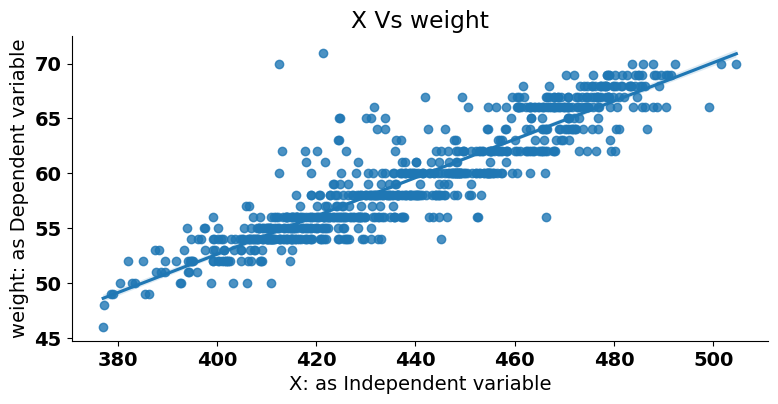

In [ ]:
sns.lmplot(x='area',y='weight',data=df,aspect=2,height=4)
plt.xlabel('X')
plt.ylabel('weight')
plt.title('X Vs weight');

In [356]:
outliers_iqr = detect_outliers_iqr(df, 'area')
outliers_zscore = detect_outliers_zscore(df, 'area')

print("Outliers using IQR method:")
print(outliers_iqr)

print("\nOutliers using Z-score method:")
print(outliers_zscore)

Outliers using IQR method:
Empty DataFrame
Columns: [perimeter, area, height, width, shape_index, compactness, weight]
Index: []

Outliers using Z-score method:
Empty DataFrame
Columns: [perimeter, area, height, width, shape_index, compactness, weight]
Index: []


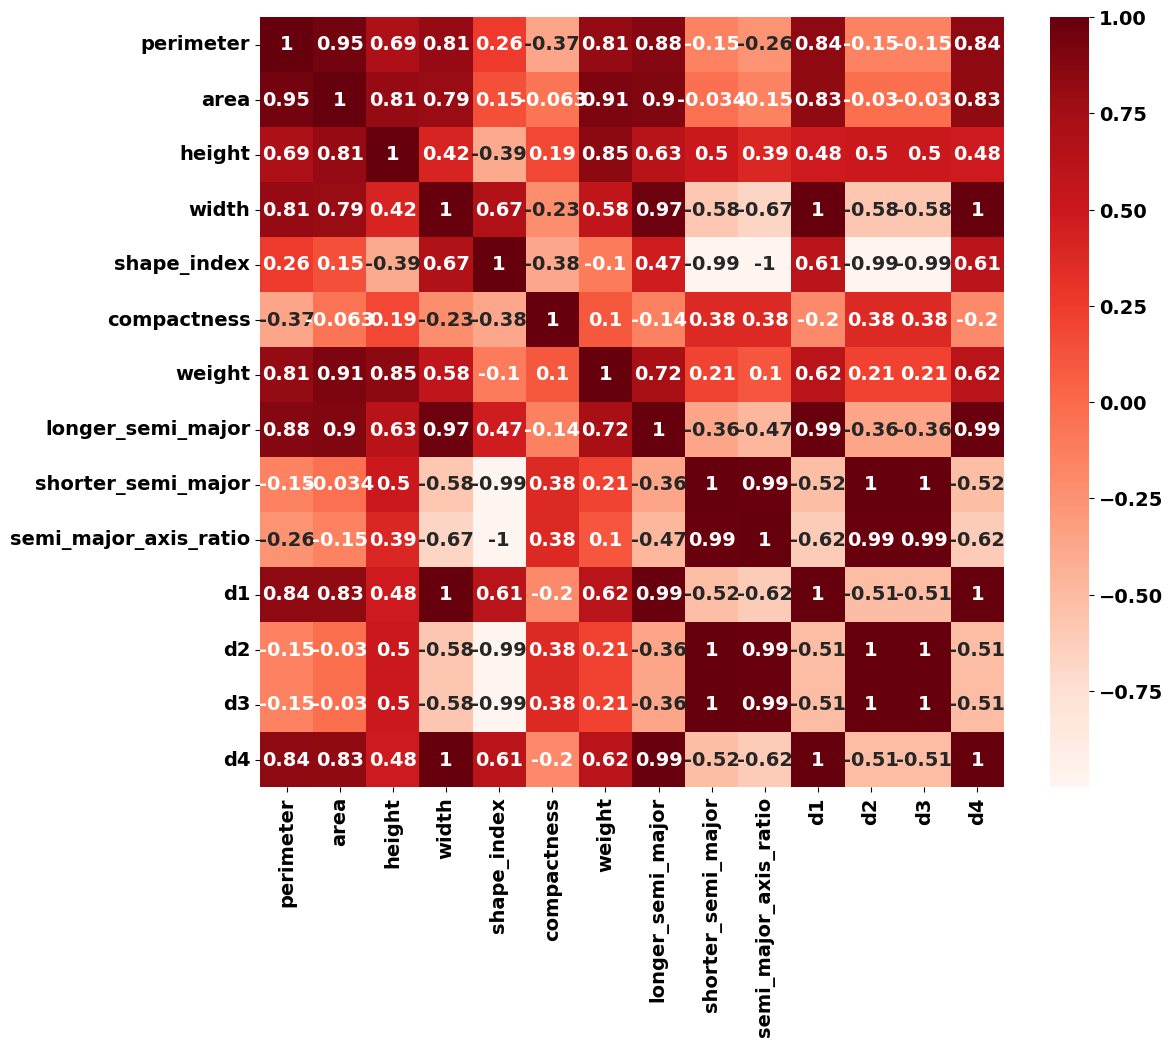

In [357]:
# correlation plot
plt.figure(figsize=(12, 10))
corr = egg_data.corr()
sns.heatmap(corr, cmap='Reds', annot=True)
plt.show()

        perimeter        area      height       width  shape_index  \
count  779.000000  779.000000  779.000000  779.000000   779.000000   
mean    18.959208  439.145528    4.750187    6.135770   129.234967   
std      0.617913   26.702765    0.154359    0.246241     5.153009   
min     17.331528  377.116071    4.339286    5.421053   113.829787   
25%     18.486333  417.214286    4.631579    5.947368   125.581395   
50%     18.933287  437.062500    4.736842    6.157895   129.213483   
75%     19.432235  462.375000    4.875000    6.315789   132.584270   
max     20.435517  504.616071    5.105263    6.803571   146.428571   

       compactness      weight  
count   779.000000  779.000000  
mean     15.343485   59.453145  
std       0.307257    5.140574  
min      14.461162   46.000000  
25%      15.117786   55.000000  
50%      15.350652   58.000000  
75%      15.530430   64.000000  
max      16.170070   71.000000  


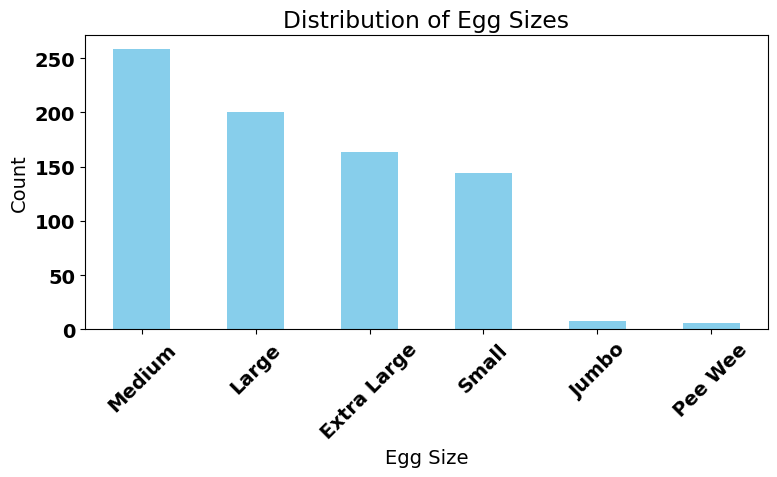

In [358]:
# Create a new column 'size' that categorizes the eggs based on their weight
df['size'] = df['weight'].apply(EggSize)

# Count the occurrences of each size
size_counts = df['size'].value_counts()

print(df.describe())

# Plot the histogram
size_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Egg Sizes')
plt.xlabel('Egg Size')
plt.ylabel('Count')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

In [6]:
kfold = KFold(n_splits=10, shuffle=True, random_state=77)

models = {
    'Linear Regression': LinearRegression(),
    # 'Decision Tree Regressor': DecisionTreeRegressor(),
    # 'Random Forest Regressor': RandomForestRegressor(),
    # 'Gradient Boost Regressor': GradientBoostingRegressor(),
}

results = {}
for model_name, model in models.items():
    best_model, test_pred, test_r2, test_rmse = evaluate_model(
        model_name, model, X_train, y_train, X_test, y_test, kfold
    )
    results[model_name] = {'model': best_model, 'predictions': test_pred, 'r2': test_r2, 'rmse': test_rmse}


Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END .......model__fit_intercept=True;, score=-5.032 total time=   0.0s
[CV 2/10] END .......model__fit_intercept=True;, score=-2.178 total time=   0.0s
[CV 3/10] END .......model__fit_intercept=True;, score=-2.501 total time=   0.0s
[CV 4/10] END .......model__fit_intercept=True;, score=-2.913 total time=   0.0s
[CV 5/10] END .......model__fit_intercept=True;, score=-1.728 total time=   0.0s
[CV 6/10] END .......model__fit_intercept=True;, score=-3.989 total time=   0.0s
[CV 7/10] END .......model__fit_intercept=True;, score=-4.006 total time=   0.0s
[CV 8/10] END .......model__fit_intercept=True;, score=-1.415 total time=   0.0s
[CV 9/10] END .......model__fit_intercept=True;, score=-1.761 total time=   0.0s
[CV 10/10] END ......model__fit_intercept=True;, score=-3.494 total time=   0.0s
[CV 1/10] END ......model__fit_intercept=False;, score=-5.034 total time=   0.0s
[CV 2/10] END ......model__fit_intercept=False;,


Best Model: Linear Regression
Test R²: 0.8832
Test RMSE: 1.7794


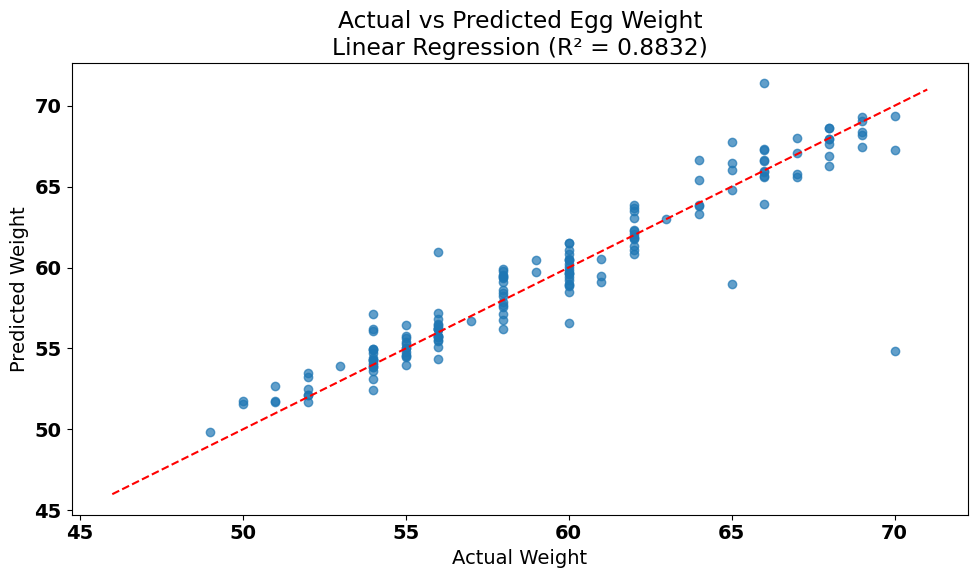

In [7]:
best_model_name = max(results, key=lambda k: results[k]['r2'])
print(f"\nBest Model: {best_model_name}")
print(f"Test R²: {results[best_model_name]['r2']:.4f}")
print(f"Test RMSE: {results[best_model_name]['rmse']:.4f}")

# Plot actual vs predicted values for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, results[best_model_name]['predictions'], alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title(f'Actual vs Predicted Egg Weight\n{best_model_name} (R² = {results[best_model_name]["r2"]:.4f})')
plt.tight_layout()
plt.show()

In [8]:
# best_param={'model__learning_rate': 0.1, 
#             'model__max_depth': 3, 
#             'model__min_samples_leaf': 2, 
#             'model__min_samples_split': 2, 
#             'model__n_estimators': 100}

# model = GradientBoostingRegressor(learning_rate=0.1, max_depth=3, min_samples_leaf=2, min_samples_split=2, n_estimators=100)
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [9]:
X_test.iloc[3], y_test.iloc[3]

(perimeter                 18.504715
 area                     403.285714
 height                     4.392857
 width                      6.000000
 shape_index              136.585366
 compactness               14.799869
 longer_semi_major          4.098214
 shorter_semi_major         0.294643
 semi_major_axis_ratio      0.071895
 d1                         3.423419
 d2                         0.414693
 d3                         0.414693
 d4                         3.423419
 Name: 51, dtype: float64,
 50.0)

In [10]:
model.predict([X_test.iloc[3]])

c:\Users\earl\Python\object-size\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([51.58274499])

In [12]:
# download the model

# joblib.dump(model, 'linear_weight_model.pkl')
# Load the modelk
loaded_model = joblib.load('linear_weight_model.pkl')
# Predict using the loaded model
loaded_model.predict([X_test.iloc[3]])

c:\Users\earl\Python\object-size\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([51.58274499])

In [13]:
loaded_model.get_params()

{'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'positive': False}